 In this project, I'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

I used text embeddings and Python to extract topic and sentiment these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |


## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [1]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI_API_KEY"]

## Install useful libraries

In [2]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.30.11 requires openai<2.0.0,>=1.13.3, but you have openai 1.3.0 which is incompatible.
langchain-openai 0.1.7 requires openai<2.0.0,>=1.24.0, but you have openai 1.3.0 which is incompatible.


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [4]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
from openai import OpenAI
client = OpenAI(api_key = openai_api_key)

In [24]:
texts = reviews['Review Text'].dropna().tolist()
# texts

In [96]:
from openai import OpenAI
import openai

client = openai.OpenAI(api_key=openai_api_key)

responses = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
)
# create embeddings
response_dict = responses.model_dump()


In [35]:
# Extract embeddings from the response using dot notation
embeddings = [response.embedding for response in responses.data]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [37]:
# reduce dimension 
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

In [38]:
embeddings_2d

array([[-43.95585  ,   9.819811 ],
       [  1.2987974,  34.332073 ],
       [ 17.056036 ,  14.522786 ],
       ...,
       [ 24.605097 , -63.898087 ],
       [ 15.20857  , -26.772028 ],
       [ -3.9110472, -58.18317  ]], dtype=float32)

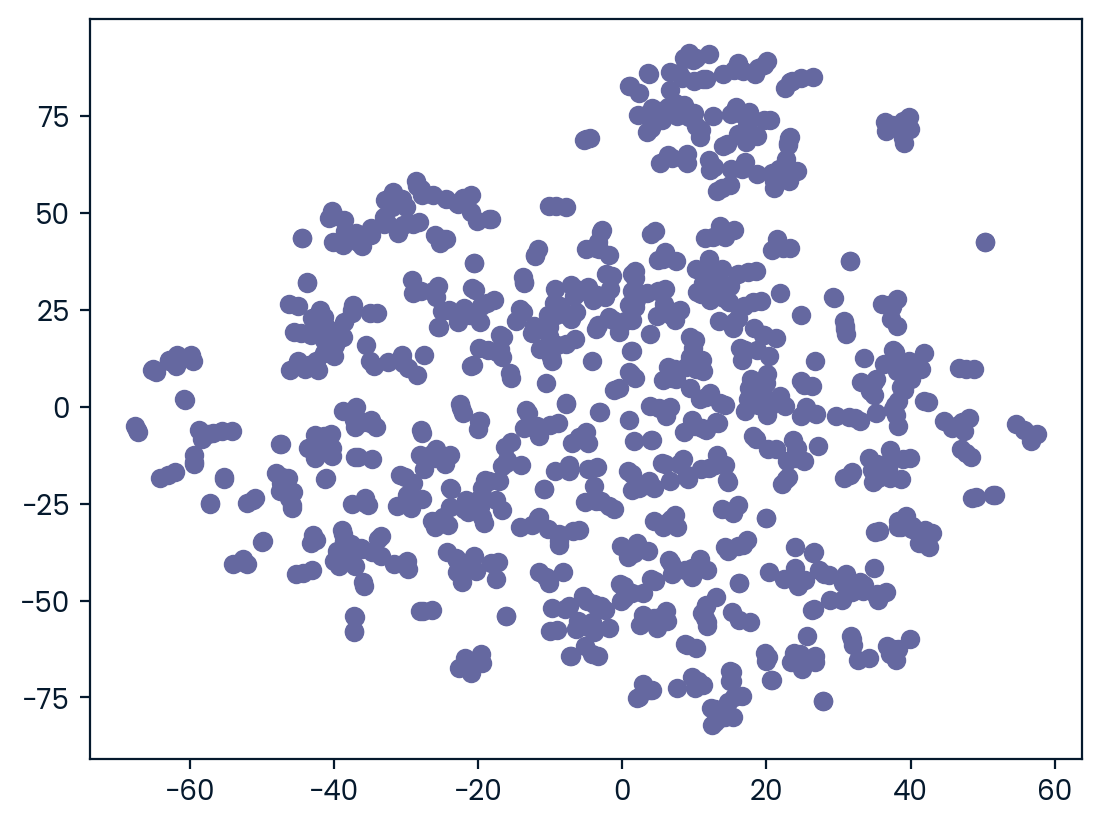

In [44]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])


In [84]:
# feedback categorization
cats = ['quality','fit','style','comfort']
cat_responses = client.embeddings.create(
    model="text-embedding-ada-002",
    input=cats
)
cat_responses_dict = cat_responses.model_dump()
cat_embeddings = [response.embedding for response in cat_responses.data]
# embedding the cats
def find_closest(cat_embeddings, inputs_embeddings):
    distances = []
    for i, embedding in enumerate(inputs_embeddings):
        dist = distance.cosine(target_embedding,embedding)
        distances.append({'distance':dist,'index':i})
    return min(distances, key=lambda x: x['distance'])

# get the closest category for a review
def assign_category(review):
    # Get embedding for the review
    review_response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=[review]  
    )
    review_embedding = review_response.data[0].embedding

    # Find the closest category
    distances = [
        (cat, distance.cosine(review_embedding, cat_embedding))
        for cat, cat_embedding in zip(cats, cat_embeddings)
    ]
    closest_category = min(distances, key=lambda x: x[1])[0]  # Get category with smallest distance
    return closest_category

# Apply the function to the reviews and create the 'category' column
# reviews['Review Text'].dropna()
category = reviews['Review Text'].dropna().apply(lambda x: assign_category(x))
category

0      fit
1      fit
2      fit
3      fit
4      fit
      ... 
995    fit
996    fit
997    fit
998    fit
999    fit
Name: Review Text, Length: 958, dtype: object

In [104]:
# feedback categorization
sentiments = ['neutral','positive','negative']
cat_responses = client.embeddings.create(
    model="text-embedding-ada-002",
    input=sentiments
)
cat_responses_dict = cat_responses.model_dump()
cat_embeddings = [response.embedding for response in cat_responses.data]

# get the closest category for a review
def assign_category(review):
    # Get embedding for the review
    review_response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=[review]  
    )
    review_embedding = review_response.data[0].embedding

    # Find the closest category
    distances = [
        (cat, distance.cosine(review_embedding, cat_embedding))
        for cat, cat_embedding in zip(sentiments, cat_embeddings)
    ]
    closest_category = min(distances, key=lambda x: x[1])[0]  # Get category with smallest distance
    return closest_category

# Apply the function to the reviews and create the 'category' column
# reviews['Review Text'].dropna()
df['sentiment'] = df['Review Text'].apply(lambda x: assign_category(x))
df

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,category,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,fit,positive
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,fit,positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,fit,negative
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,fit,positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,fit,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1047,70,NaN,Received these as a christmas gift from my dau...,5,1,3,General,Bottoms,Pants,fit,positive
996,996,936,37,Gorgeous!!!,"Every year around this time, our beloved retai...",5,1,8,General,Tops,Sweaters,fit,neutral
997,997,936,36,Gorgeous,I tried on this sweater in the store and immed...,5,1,1,General,Tops,Sweaters,fit,neutral
998,998,854,29,So soft!,Super soft and comfortable. runs a little larg...,5,1,0,General Petite,Tops,Knits,fit,neutral


In [87]:
df = reviews.dropna(subset='Review Text')
df['category'] = category
df

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,category
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,fit
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,fit
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,fit
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,fit
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,fit
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1047,70,NaN,Received these as a christmas gift from my dau...,5,1,3,General,Bottoms,Pants,fit
996,996,936,37,Gorgeous!!!,"Every year around this time, our beloved retai...",5,1,8,General,Tops,Sweaters,fit
997,997,936,36,Gorgeous,I tried on this sweater in the store and immed...,5,1,1,General,Tops,Sweaters,fit
998,998,854,29,So soft!,Super soft and comfortable. runs a little larg...,5,1,0,General Petite,Tops,Knits,fit


similarity search 


In [95]:
# get the closest category for a review
# Get embedding for the review
review_responses = client.embeddings.create(
    model="text-embedding-ada-002",
    input=df['Review Text'].tolist()  
    )
reviews_embeddings = [response.embedding for response in review_responses.data]


def similarity_search(input):
    input_response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=[input]  
    )
    input_embedding = input_response.data[0].embedding
    # Find the closest category
    distances = []
    for review in reviews_embeddings:
        dist =  distance.cosine(input_embedding, review)
        distances.append(dist)
    closest_indices = np.argsort(distances)[1:4]
    return df['Review Text'].iloc[closest_indices]

similarity_search('Absolutely wonderful - silky and sexy and comfortable')

    
    

502    Very comfortable and versatile. got lots of co...
47     Very comfortable, material is good, cut out on...
81     Loved this top. great design. comfortable and ...
Name: Review Text, dtype: object